# Model Fit and Application Stage

This notebook presents the steps to fit and evaluate classification models and to apply a selected model to the entire dataset to generate a new candidate corpus. We will use the philosophy/non-philosophy label.

The structure is as follows:

1. importing data from the labelling stage,
2. examing the labelled data and divide into testing and training sets (looking after class balance in the training set),
3. setting up and fitting a `scikit-learn` pipeline for a naive bayes classifier and choosing model parameters using cross validation,
4. evaluating the model both qualitatively and quantitiatively, and
5. applying the model to the entire processed dataset to generate a new candidate corpus.

## Imports

We will use `sklearn` for model fit. While the main method used in this project is Naive Bayes Classification, code for the use of support vector machines is also provided.

In [1]:
import os
import pickle

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from nltk.corpus import stopwords

import numpy as np

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

import pandas as pd


stopword_set = set(stopwords.words('english'))

Set the current iteration.

In [2]:
ITERATION = 1

We load the labelled data set from the previous stage.

In [3]:
labels = pd.read_pickle(f'../Labels/labels_{ITERATION}.tar.gz')

We check that they are in the right form:

In [4]:
labels

,NZ,Notes,Philosophy,Philosophy Type,Readable,Writing Type,Text
LT_18971209_ARTICLE7,None,,False,None,True,None,[YOUR PALE AND SALLOW GIRLS NEED ATTENTION. TH...
NZTIM_18860722_ARTICLE11,None,,False,None,True,None,[By.Eleotbio Telegraph—Copyright. (BEDIEB’S TE...
WC_18810721_ARTICLE7,None,,False,None,True,None,"[July 18. ; The ""Very Eev. A. P. Stanley, Dean..."
DUNST_18980513_ARTICLE3,None,,False,None,True,None,"[(“ Weekly Press.”), There is something pathet..."
OAM_18960702_ARTICLE35,None,,False,None,True,None,[A novel suggestion as to the division of 1 a ...
...,...,...,...,...,...,...,...
AS_18821010_ARTICLE41,False,,True,r,True,p,[An immense audience assembled in the Opera Ho...
NEM_18840707_ARTICLE12,True,,True,r,True,p,[to assume that it was self evident. Ingenious...
ODT_18980127_ARTICLE31,True,,True,r,True,p,[Dr Stordeur gave a lecture at the Oddfellows'...
NZTIM_18960806_ARTICLE1,True,,True,e,True,f,[A Chief Apostle of Vegetarianism-cura- Mity t...


## Data

### Examine

It is worth looking at the class balance for the labels you are interested in. In this case, I'll look at `Philosophy`, `Philosophy Type` and `Writing Type`. 

<AxesSubplot:>

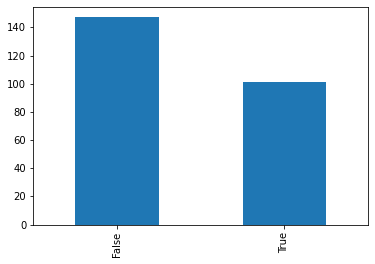

In [5]:
labels['Philosophy'].value_counts().plot(kind='bar')

In the case of any specialist subject, it will be much easier to get items which do not fit the criteria than those which do. So, even with a strong attempt to get a balanced set of labels, we should still expect to not quite have a 50-50 split here.

<AxesSubplot:>

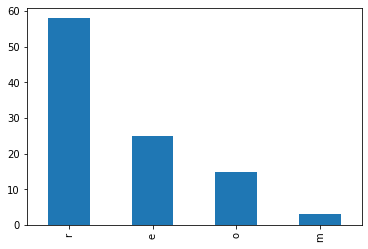

In [6]:
labels['Philosophy Type'].value_counts().plot(kind='bar')

<AxesSubplot:>

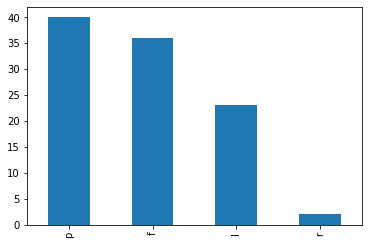

In [7]:
labels['Writing Type'].value_counts().plot(kind='bar')

In this worksheet, we'll set up a philosophy/non-philosophy classifier.

In [8]:
non_phil_count = labels['Philosophy'].value_counts()[0]
phil_count = labels['Philosophy'].value_counts()[1]

In [9]:
print(f"Philosophy item count: {phil_count}")
print(f"Non-philosophy item count: {non_phil_count}")

Philosophy item count: 101
Non-philosophy item count: 147


### Training/Test Split

To train a classifier to pick out blocks with philosophical content and those which do not, we begin by making a training/testing split. We take 75% for training and 25% for testing. We sample from each class seperately and then assign the remaining rows to the test dataset.

In [10]:
training_phil = (
    labels.loc[labels['Philosophy']==True]
    .sample(n=phil_count//4 * 3, random_state=1)
)

training_nonphil = (
    labels.loc[labels['Philosophy']==False]
    .sample(n=non_phil_count//4 * 3, random_state=1)
)

training = training_phil.append(training_nonphil)

del training_phil, training_nonphil

test = labels.loc[[i for i in labels.index if not i in training.index]]

### Upsampling

We want our training data to be roughly 50/50 in terms of philosophy, so we duplicate a random collection of philosophy items. The following code duplicates 5 random items until the number of philosophy items is close to the number of nonphilosophy items.

In [11]:
j = 0
balanced = False
non_phil_training = len(training[training['Philosophy'] == False])
while balanced == False:
    indices_to_double = (
        training[training['Philosophy']==True]
        .sample(n=5, random_state=j) 
        .index
    )
    for i in indices_to_double:
        training.loc[f'{i}_upsample_{j}'] = training.loc[i]
    balanced = (
        non_phil_training - 5 < 
        len(training[training['Philosophy']==True]) <= 
        non_phil_training + 5
    )
    j += 1

The results, as follows, show that the number of philosophy and non-philosophy articles is now the same.

In [12]:
training['Philosophy'].value_counts()

False    108
True     105
Name: Philosophy, dtype: int64

## Set up Pipeline and Fit Model

The following pipeline sets up the preprocessing steps for our classifier. At the dictionary creation stage, it removes stopwords and requires words to be at least three characters long. It also sets a `max_df` value, which at `0.4` insists that any word in the dictionary can appear in no more than 40% of the items, and a `min_df` value, which at `5` insists that any word in the dictionary must be in at least five items. These two hyperparaameters are just default values. The actual values will be determined by a grid search. We include a TF-IDF transformer and feed into the `MultinomialNB` function. Note that we are training a binary classifier rather than a multi-class classifier. Even so, this is handled by the multinomial Naive Bayes function provided by sci-kit learn.

In [13]:
classifier = Pipeline([
    ('vect', CountVectorizer(
        max_df=0.4,
        min_df=5,
        stop_words=stopword_set, 
        token_pattern=r'(?u)\b\w\w\w+\b')),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

We extract the training and test data as features. First, we define a helper function to convert the articles to a single string rather than a list of strings.

In [14]:
def blocks2string(text_blocks):
    """Given textblocks return blocks as single string."""
    return '\n'.join(text_blocks)

In [15]:
training_features = training['Text'].map(blocks2string).astype('string').to_numpy()
training_labels = training['Philosophy'].to_numpy().astype(bool)

Rather than just fitting the above model, we can set a range of parameters and use a grid cross validation search. The details of each of these parameters can be viewed in the `sklearn` [documentation](https://scikit-learn.org/stable/). But note here that we allow for up to 3-grams in our features. That is, we allow the model to know about groups of three adjacent words. We also allow for the dictionary to use tfidf representation rather than standard bag of words frequency counts.

In [16]:
parameters = {
    'vect__min_df': [2, 5, 7, 10, 15],
    'vect__max_df': [0.2, 0.3, 0.4, 0.5, 0.6],
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': [0.5, 0.75, 1]
}

The following cell fits the model, and may take some time to run. We use overall accuracy as the training measure.

***TODO: set this up to run in parallel***

In [17]:
gs_clf = GridSearchCV(classifier, parameters, cv=5, n_jobs=1)
gs_clf.fit(training_features, training_labels)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(max_df=0.4, min_df=5,
                                                        stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
                                                                    'any',
                                                                    'are',
        

We look at out best score:

In [20]:
gs_clf.best_score_

0.9483942414174973

...and the parameters for which it was achieved:

In [21]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 0.5
tfidf__use_idf: True
vect__max_df: 0.4
vect__min_df: 2
vect__ngram_range: (1, 1)


For the first iteration model included by default in this notebook, we have a smoothing factor of 0.5, a tf-idf representation of the documents, we accept words in at least two items and do not use n-grams.

Note that the `GridSearchCV` object refits the chosen model on the full dataset. Consequently, we do not need to manually retrain the classifier using the found hyperparamenters.

In [37]:
best_classifier = gs_clf.best_estimator_

We save this model:

In [38]:
with open(f'../Classifiers/classifier_{ITERATION}.tar.gz', 'wb') as fout:
    pickle.dump(best_classifier, fout)

## Model Evaluation

We apply both quantitative and qualitative evaluation to the model. The quantitative evaluation consists of fitting the model to the test data set and examing the accuracy, recall, and precision. Having examing this, we then look at the items which are misclassified and consider what they tell us about how the model is failing.

### Quantitative

The accuracy given above was for the training set. This will, in any but the strangest situations, be higher than the accuracy attained for the test set. We apply the model to the test set now:

In [114]:
test_features = test['Text'].astype('string').to_numpy()
test_labels = test['Philosophy'].to_numpy().astype(bool)
predicted = best_classifier.predict(test_features)

In [115]:
np.mean(predicted == test_labels)

0.9333333333333333

The above shows that we have a 93% accuracy for the test dataset. However, accuracy is not the only metric, it may be that false negatives or false positives are more common than one another. We need to look at the [_precision_ and _recall_](https://en.wikipedia.org/wiki/Precision_and_recall).

In [116]:
confusion_matrix = metrics.confusion_matrix(test_labels, predicted)
confusion_matrix

array([[62,  2],
       [ 4, 22]])

In [117]:
tp = confusion_matrix[1][1]
fn = confusion_matrix[1][0]
fp = confusion_matrix[0][1]
tn = confusion_matrix[0][0]
recall = tp/(tp+fn)
precision = tp/(tp+fp)
print(f'recall: {recall}')
print(f'precision: {precision}')

recall: 0.8461538461538461
precision: 0.9166666666666666


The recall tells us the ratio of true positives to total philosophy items in the test set. That is, of the philosophy items, what proportion are picked out by the model. The precision tells us, of the items classified by the model as philosophy, how many are actually philosophy. Both are high. Usually, it is best to balance these. Attempts to maximise recall will tend to increase the number of false positives, while attempts to increase precision will tend to increase the number of false negatives.

### Qualitative evaluation

At this point, it may be that there is something in common between the misclassified articles which can be taken in to the labelling stage. It may also be that the articles which are misclassified are those which we already considered borderline calls at the labelling stage.

#### False negatives.

We begin by looking at the false negatives. Our labelling in this case have given us a few other variables by which to interpret the false positives. We can look, for instance, at the `Philosophy type` and `Writing Type` variables.

In [118]:
test['Predicted'] = predicted
false_negatives = test.loc[(test['Philosophy'] == True)&(test['Predicted'] == False)]
false_negatives['Philosophy Type'].value_counts()

o    3
e    1
Name: Philosophy Type, dtype: int64

In [119]:
false_negatives['Writing Type'].value_counts()

f    3
p    1
Name: Writing Type, dtype: int64

We have three in the 'other' category for philosophy type and one in the 'ethics'. So we shouldn't be worried if we are mainly interested in 'religion and science' articles. We have three 'first order' bits of writing and one report of a public event. Let's look at these in more detail:

In [120]:
false_negatives

,NZ,Notes,Philosophy,Philosophy Type,Readable,Writing Type,Text,Predicted
NEM_18920804_ARTICLE37,None,,True,o,True,f,[(From the Danedin Evening Star.) The resignat...,False
LT_18860204_ARTICLE16,True,first paragraph,True,e,True,f,[Sie Julius Vogel has been declared elementary...,False
HBT_18650904_ARTICLE11,None,Mention of phil books in library,True,o,True,f,"[t(OOD Woeds July, 1865 ; Sunday Magazine —Jul...",False
WI_18661215_ARTICLE14,True,contains report of lecture on 'philosophy of d...,True,o,True,p,[Ancient Okpeb of Remiabitks.— A Tent of the a...,False


We can also look at the plain text of these:

In [121]:
def print_article_text(index, dataframe):
    article_text = dataframe.loc[index]['Text']
    print (f"""
{index}
    
{dataframe.loc[index]['Philosophy Type']} -{dataframe.loc[index]['Notes']} 

{article_text}
""")
indices = false_negatives.index
interact(print_article_text, index=indices, dataframe=fixed(false_negatives))

interactive(children=(Dropdown(description='index', options=('NEM_18920804_ARTICLE37', 'LT_18860204_ARTICLE16'…

<function __main__.print_article_text(index, dataframe)>

`WI_18661215_ARTICLE14` is an excellent example of a compositie piece in which only some of the piece is what we are after (the section 'philosophy of dreams'.

#### False positives

We now look at the false positives. Since these were not labelled with `Philosophy Type` or, in this version of the project, with `Writing Type` (***NB:*** not labelling non-philosophy with writing type was a mistake in the design of the project), we can't look at the distribution of these. We go straight to the dataframe and the plain text. 

In [71]:
false_positives = test.loc[(test['Philosophy'] == False)&(test['Predicted'] == True)]
false_positives

,NZ,Notes,Philosophy,Philosophy Type,Readable,Text,Writing Type,Predicted
LT_18801016_ARTICLE32,None,,False,None,True,1h i fallowing is the result of the Annuel Pas...,None,True
WH_18740318_ARTICLE8,None,,False,None,True,"(Communicate;!),\nA very remarkable revival mo...",None,True


In [135]:
def print_article_text(index, dataframe):
    article_text = dataframe.loc[index]['Text']
    print (f"""
{index}
    
{dataframe.loc[index]['Philosophy Type']} -{dataframe.loc[index]['Notes']} 

{article_text}
""")
indices = false_positives.index
interact(print_article_text, index=indices, dataframe=fixed(false_positives))

interactive(children=(Dropdown(description='index', options=('DUNST_18980513_ARTICLE3', 'ESD_18890912_ARTICLE3…

<function __main__.print_article_text(index, dataframe)>

Of the two items which are falsely listed as philosophy, we have one which contains a list of students and their results in subjects including philosophy. The other is a report of a religious revival meeting in Scotland. There are mentions of philosophy in passing and of students at the university and, indeed, various professors. This kind of item is not far from what we might be interested in if interested in the relationship between say, religion and secular thought. From this, I'd conclude that we shouldn't be too worried that our false positives will put our corpus off track.

### A Model Application Trick For Composite Articles

The problem of composite articles seems to arise because the 'philosophical bit' of the articles is outweighed by other material. Since our labelling happens at the level of item, we can't train the classifier with portions of items. However, we can cut up items into smaller chunks and run each chunk through the trained classifier, giving a positive classification if one chunk is labelled as philosphy.

We don't use text blocks, as they are of unreliable length. So, having turned the 'blocks' into a single string, we now turn the strings into a list of 'chunks' of 3000 characters (which is chosen to be around 400 words on average). Other options are possible here.

The following function (`string2chunks`) divides the string into a list of strings of the required length.

In [146]:
def string2chunks(in_string, max_chunk_length = 3000):
    string_length = len(in_string)
    out_string_count = (string_length // max_chunk_length) + 1
    out_strings = []
    
    for i in range(out_string_count):
        start_point = i * max_chunk_length
        
        # Handle case in which there is less than max_chunk_length
        # characters left.
        if (len(in_string) - start_point) < max_chunk_length:
            end_point = len(in_string)
        else:
            end_point = start_point + max_chunk_length
            
        chunk = in_string[start_point:end_point]
        out_strings.append(chunk)
        
    return out_strings

We now copy the test dataframe and divide the features into blocks, run them through the best classifier, and output the overall accuracy.

In [151]:
test_chunks = test.copy(deep=True)

test_chunks['Text'] = test_chunks['Text'].map(blocks2string).map(string2chunks)

test_chunks = test_chunks.explode('Text')

test_features = test_chunks['Text'].astype('string').to_numpy()
test_labels = test_chunks['Philosophy'].to_numpy().astype(bool)
test_chunks['Predicted'] = best_classifier.predict(test_features)

np.mean(test_chunks['Predicted'] == test_labels)

0.8675213675213675

Note that this is a decrease in stated accuracy. However, this is not our final labelling. The suspision is that the false negative rate has gone up. We generate the confusion matrix and then the recall and precision.

In [152]:
confusion_matrix = metrics.confusion_matrix(test_labels, test_chunks['Predicted'])
confusion_matrix

array([[147,  11],
       [ 20,  56]])

In [153]:
tp = confusion_matrix[1][1]
fn = confusion_matrix[1][0]
fp = confusion_matrix[0][1]
tn = confusion_matrix[0][0]
recall = tp/(tp+fn)
precision = tp/(tp+fp)
print(f'recall: {recall}')
print(f'precision: {precision}')

recall: 0.7368421052631579
precision: 0.835820895522388


We look at an article to see how it is being divided up.

In [155]:
test_chunks.loc['WI_18661215_ARTICLE14']

,NZ,Notes,Philosophy,Philosophy Type,Readable,Writing Type,Text,Predicted
WI_18661215_ARTICLE14,True,contains report of lecture on 'philosophy of d...,True,o,True,p,Ancient Okpeb of Remiabitks.— A Tent of the ab...,False
WI_18661215_ARTICLE14,True,contains report of lecture on 'philosophy of d...,True,o,True,p,ies. We would su^gost : to those who intend pa...,False
WI_18661215_ARTICLE14,True,contains report of lecture on 'philosophy of d...,True,o,True,p,"inst Wilson o murdering llr JJobson, continued...",True
WI_18661215_ARTICLE14,True,contains report of lecture on 'philosophy of d...,True,o,True,p,"ower called by Professor JVfaas of Halle, the ...",False
WI_18661215_ARTICLE14,True,contains report of lecture on 'philosophy of d...,True,o,True,p,believed that this matter had been already ?of...,False
WI_18661215_ARTICLE14,True,contains report of lecture on 'philosophy of d...,True,o,True,p,"last says tho llawke's Bay Herald, Maika, a s...",False
WI_18661215_ARTICLE14,True,contains report of lecture on 'philosophy of d...,True,o,True,p,itory to attack Hawko's Hay; and that the Hau ...,False
WI_18661215_ARTICLE14,True,contains report of lecture on 'philosophy of d...,True,o,True,p,"elf is :i very ! line one, with a"" beautiful s...",False
WI_18661215_ARTICLE14,True,contains report of lecture on 'philosophy of d...,True,o,True,p,"n he expected, and having to swim nlmosfc the ...",False
WI_18661215_ARTICLE14,True,contains report of lecture on 'philosophy of d...,True,o,True,p,ie rush Jo the northern diggings is setting in...,False


We aggregate the items so that they are classed as philosophy if they have any philosophy blocks.

In [157]:
test_chunks = test_chunks.groupby(test_chunks.index).agg(
    Text = ("Text", ''.join),
    Predicted = ("Predicted", any)
)

test = test.drop('Predicted', axis=1).join(test_chunks['Predicted'])

We look at the false positives.

In [158]:
false_positives = test.loc[(test['Philosophy'] == False)&(test['Predicted'] == True)]
false_positives

,NZ,Notes,Philosophy,Philosophy Type,Readable,Writing Type,Text,Predicted
DUNST_18980513_ARTICLE3,None,,False,None,True,None,"[(“ Weekly Press.”), There is something pathet...",True
ESD_18890912_ARTICLE37,None,,False,None,True,None,"[[By Onr. Special Reporters.!, OAMARU, Septemb...",True
WI_18480930_ARTICLE10,None,,False,None,True,None,"[[From the Examiner, September 23,] We printed...",True
LT_18801016_ARTICLE32,None,,False,None,True,None,[1h i fallowing is the result of the Annuel Pa...,True
LWM_18981104_ARTICLE19,None,,False,None,True,None,[The greater part of the lions exhibited ta th...,True
ODT_18820610_ARTICLE31,None,At end: complaint about 'freethinkers' writing...,False,None,True,None,[(Prom Otago Witness.) The political weather p...,True
TC_18630623_ARTICLE16,None,,False,None,True,None,"[Age op the Pyeajiids.—Mahmoud Bey, the astron...",True
WH_18740318_ARTICLE8,None,,False,None,True,None,"[(Communicate;!),, A very remarkable revival m...",True


And now the false negatives.

In [160]:
false_negatives = test.loc[(test['Philosophy'] == True)&(test['Predicted'] == False)]

false_negatives

,NZ,Notes,Philosophy,Philosophy Type,Readable,Writing Type,Text,Predicted
NEM_18920804_ARTICLE37,None,,True,o,True,f,[(From the Danedin Evening Star.) The resignat...,False
HBT_18650904_ARTICLE11,None,Mention of phil books in library,True,o,True,f,"[t(OOD Woeds July, 1865 ; Sunday Magazine —Jul...",False


In [ ]:
NEM_18920804_ARTICLE37 	None 		True 	o 	True 	(From the Danedin Evening Star.) The resignati... 	f 	False
LT_18860204_ARTICLE16 	True 	first paragraph 	True 	e 	True 	Sie Julius Vogel has been declared elementary ... 	f 	False
HBT_18650904_ARTICLE11 	None 	Mention of phil books in library 	True 	o 	True 	t(OOD Woeds July, 1865 ; Sunday Magazine —July... 	f 	False
WI_18661215_ARTICLE14 	True 	contains report of lecture on 'philosophy of d... 	True

More are being misclassified, but we did get out composite items. Here, we could again generate a confusion matrix to work out accuracy, recall, and precision.

## Apply to Whole Dataset

This section takes the classifier and applies it to the processed dataset to produce a new candidate corpus. It may be convenient here to load a previously-fit model.

In [108]:
with open(f'../Classifiers/classifier_{ITERATION}.tar.gz', 'rb') as fin:
  best_classifier = pickle.load(fin)

We will be filtering out short articles from each of the slices of the processed data. These are often misclassified (and, indeed, assigned to the positive category in the case of a binary classification) and tend to clutter the new candidate corpus. This filtering is facilitated with helper functions.

In [113]:
def filter_short_articles(string):
    if len(string)<800:
        string = ''
    return string



def apply_classifier(classifier, df):
    features = (
        df['Text']
        .map(blocks2string)
        .map(filter_short_articles)
    )
    features.drop(features[features==''].index, inplace=True) # remove empty strings
    predictions = pd.Series(data=best_classifier.predict(features))
    predictions.index = features.index
    # Select title and text columns classified as True.
    wanted_items = df[['Title', 'Text']].loc[predictions[predictions].index] 
    return wanted_items
    

We now iterate through the processed data to produce a new candidate dataframe. ***TODO: run in parallel.***

In [114]:
slices = 26 # number of slices into which dataset was processed.

candidate_item_dfs = []
for i in range(slices):
    print(f"Loading corpus slice {i}")
    df = pd.read_pickle(f'../Dataset/processed-data/corpus_df_{i}.tar.gz')
    candidate_items = apply_classifier(best_classifier, df)
    candidate_item_dfs.append(candidate_items)
    del df
        
candidate_corpus = pd.concat(candidate_item_dfs)

Loading corpus slice 0
Loading corpus slice 1
Loading corpus slice 2
Loading corpus slice 3
Loading corpus slice 4
Loading corpus slice 5
Loading corpus slice 6
Loading corpus slice 7
Loading corpus slice 8
Loading corpus slice 9
Loading corpus slice 10
Loading corpus slice 11
Loading corpus slice 12
Loading corpus slice 13
Loading corpus slice 14
Loading corpus slice 15
Loading corpus slice 16
Loading corpus slice 17
Loading corpus slice 18
Loading corpus slice 19
Loading corpus slice 20
Loading corpus slice 21
Loading corpus slice 22
Loading corpus slice 23
Loading corpus slice 24
Loading corpus slice 25


In [115]:
candidate_corpus

,Title,Text
LCP_18750115_ARTICLE9,THE GLASGOW POLICE CELLS.,[The special correspondent of. the Daily News ...
LCP_18750212_ARTICLE3,UNTITLED,[The AVEB4GE Barber.— He is in a state of pers...
LCP_18750212_ARTICLE11,THE ORIGIN OF TYPHOID FEVER.,[Recent outbreaks of zymotic diseases in Engla...
LCP_18750220_ARTICLE3,"The Arrow Observer, AND LAKES DISTRICT CHRONIC...",[The year of 1875 is now fairly fleeting on it...
LCP_18750227_ARTICLE10,Volunteers.,"[TO THE EDITOR ARROW OBSERVER. Sir,—l have lon..."
...,...,...
MS_18840421_ARTICLE19,A Thoughtful Husband.,[A Detroit lady who is.(A«^jficf .'jjto heart...
MS_18840919_ARTICLE12,CORRESPONDENCE.,"[Mr Bonn In Reply., (TO THE EDITOR OP THB STAN..."
MS_18840214_ARTICLE3,Manawatu Standard (PUBLISHED DAILY.) Suivant l...,[Ii is some relief to know that an effort is t...
MS_18840407_ARTICLE16,Spiritualism in Woodville.,"[(Oorreepondent of Exchange.), have been field..."


So the first iteration produces a dataframe with around 200,000 items. We save it:

In [117]:
candidate_corpus.to_pickle(f'../Corpora/candidate_corpus_{ITERATION}.tar.gz')

## Next Step

We now have a new `candidate_corpus` dataframe and can return to the "Corpus Evaluation" notebook.